**CONSTANT HEIGHT STM IMAGES**
------------------------------


Theory Background
-----------------

Prediction of STM images requires a knowledge of the **electronic structure** of the molecule and a theory of how STM works.

The standard theory of how STM works is based on the Tersoff-Hammann aproximation (https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.50.1998):
**the tunneling current is proportional to the local density of states (LDOS)**:

$$
I(\vec{r}, V) \propto \int_0^V LDOS(\vec{r}, E_f - V + \epsilon) \,d\epsilon\
$$
The LDOS at a certain energy is calculated from the electron density, computed as $\psi(\vec{r}) \psi^*(\vec{r})$, considering only  wavefunctions at that energy.

The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

In summary, to compute constant height STM images, we need:

1.- Obtain atomic coordinates (for example, from a previous geometry optimization calculation)

2.- Compute the eigenstates (wavefunction coefficients) and eigenvalues (energies). We will use **SIESTA** for this.

3.- Compute electron density of selected states and compute the STM current $I(\vec{r}, V)$ for any point in space $\vec{r}$ (at a constant height $z$), given the voltage bias $V$. We will use **python** for this.

$$
I(\vec{r}, V) \propto \int_0^V \sum_{i} \left[n(-V + E, \epsilon_i) *  \psi_i(\vec{r}) \psi_i^*(\vec{r})\right] \,dE\
$$

Python implementation of STM simulation
---------------------------------------
We first import of required libraries

In [3]:
import sisl
from sisl import *
import sisl.viz
import numpy as np
import matplotlib.pyplot as plt

## Analysis of SIESTA Results
**Load SIESTA Calculation**

Once the SIESTA run has finished, to load SIESTA results into python you can do:

```python
sisl.get_sile("path/to/my/file.fdf").read_hamiltonian()
```

as we have done in previous lab sessions.

In [4]:
fdf = get_sile("../run/stm.fdf")

In [5]:
H = fdf.read_hamiltonian()

In [10]:
molec = H.geometry

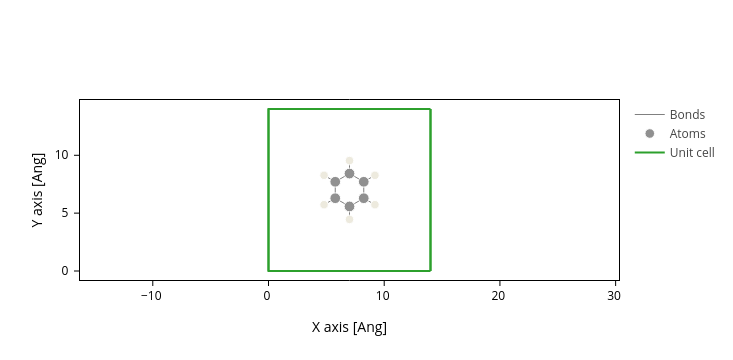

In [5]:
molec.plot(axes="xy")

## Eigenstates

Once you have a hamiltonian, you can get all Eigenstates with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. 
- Each eigenstate has its energy stored under the `.eig` property.
- We can find the HOMO and LUMO.
- We can use the `.dos`  method to obtain the density of states DOS(E).
- In sisl we can plot pdos directly in a given Energy range with something like `H.plot.pdos(data_Erange=[-10,10],nE=1200,Erange=[-10,10]) `

In [6]:
es=H.eigenstate()

In [7]:
es.eig

array([-16.33995652, -13.69324101, -13.69252644, -10.1138892 ,
       -10.11350652,  -8.01491573,  -6.56817621,  -6.1713395 ,
        -5.50724443,  -5.50627282,  -4.22312382,  -3.64120263,
        -3.64038941,  -1.64538185,  -1.64471071,   3.27233849,
         3.27264538,   5.14290337,   6.15562798,   6.156023  ,
         6.9103075 ,   6.91078352,   6.98696098,   7.70640457,
         8.75989765,   9.73694772,   9.78243883,  10.14685502,
        10.1478689 ,  10.58670856,  10.5888617 ,  10.94315755,
        10.94320515,  12.47959413,  12.47985574,  12.50395164,
        13.28113462,  13.28122621,  13.4603012 ,  13.55917322,
        13.55970522,  14.66095655,  15.81792977,  16.81369127,
        16.81514098,  17.62228868,  17.65590792,  17.65761405,
        18.60302842,  18.9708367 ,  18.9711427 ,  20.69039612,
        21.04852293,  22.4392446 ,  22.44082743,  23.05108247,
        23.05291917,  23.31487739,  23.316348  ,  25.60008703,
        25.60386505,  26.66795101,  27.16934893,  27.80

In [8]:
idx_lumo = (es.eig > 0).nonzero()[0][0] #trick to obtain the LUMO as first positive eigenvalue

In [9]:
print(idx_lumo)

15


In [10]:
print("HOMO E=",es.eig[idx_lumo-1]," eV")
print("LUMO E=",es.eig[idx_lumo]," eV")

HOMO E= -1.644710708154887  eV
LUMO E= 3.2723384944940688  eV


-----------------------------------------------------------------------------------
## Plotting Local Density of States

Create a grid and fill the grid with LDOS

**To compute wavefunctions on the grid:**

To compute $\psi (\vec{r})$ you need three things.

1. **The eigenstate coefficients.** Once you have a hamiltonian, you can get all of them with `H.eigenstate()`. Then you can loop this object to get each individual eigenstate. Each eigenstate has its energy stored under the `.eig` property.
2. **A grid of points in space.** You can create one with `sisl.Grid(geometry, shape=(100, 100, 100))`. This will create a grid of $100x100x100$ points within the cell of your geometry.
3. **A function to project the wavefunction into the grid.** The eigenstate object has a `wavefunction` method ([docs](https://zerothi.github.io/sisl/api/generated/sisl.physics.electron.EigenstateElectron.html#sisl.physics.electron.EigenstateElectron.wavefunction)) that will project the wavefunction into an already initialized grid.
4. Once you have the wavefunction, you can calculate the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$.
5. The result can be saved in a '.cube' file and plotted with VMD 

Remember that we have done this already on the first SIESTA lab, with a water molecule and with $C_{60}$.


In [11]:
g = Grid(0.2, lattice=molec.lattice)  #defines a grid matching with our system

Save a state (for example, LUMO) in cube file

In [12]:
es[idx_lumo].wavefunction(g)
g.write('LUMO.cube')

g.fill(0) # reset the grid values to 0

Save Electron Density

In [13]:
g2 = Grid(0.2, lattice=molec.lattice) 

In [14]:
es[idx_lumo].wavefunction(g)
g2=g*g.grid.conj() 
g2.write('LUMOdens.cube')
g2.fill(0) # reset the grid values to 0

We can easily save the electron density including a range of states

In [15]:
Gt = Grid(0.2, lattice=molec.lattice) 
for n in range(idx_lumo-4,idx_lumo):
    print("adding state",n)
    g.fill(0)
    es[n].wavefunction(g)
    Gt = Gt + g*g.grid.conj()
Gt.write('several_states.cube')
Gt.fill(0)

    

adding state 11
adding state 12
adding state 13
adding state 14


# STM images #

**Remember**: The value of the tip bias V determines **which states are explored**:  

$V = V_{tip} - V_{sample} > 0$ : sample electrons go to the tip, so the images **show occupied states**.

$V = V_{tip} - V_{sample} < 0$ : tip electrons go to the sample, so the images **show unoccupied states**.

Now we can create a function `STM_grid(H, V)` that creates a grid adding all the states that contribute to the electron density $\psi_i(\vec{r}) \psi_i^*(\vec{r})$ relevant to the STM image.

The `STM_grid(H, V)` function need the Hamitonian (the object `H`) and the value of the voltage `V`.

In [12]:
def STM_grid(H, V):
    gridT = sisl.Grid((200, 200, 200), geometry=molec)
    grid = sisl.Grid((200, 200, 200), geometry=molec)
    gridT.fill(0)
    E=-V
    for i in range(0,len(es)):
        #Negative V: electrons go from tip to sample filling unoccupied states from 0 to E
        if 0<es[i].eig<E:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT
        #Positive V: electrons with energies between E and 0 leave the sample and go to the tip
        if E<es[i].eig<0:    
            grid.fill(0)
            print("adding state",i)
            es[i].wavefunction(grid)
            GT=grid*grid.grid.conj()
            gridT=gridT+GT 
    result=gridT
    return result

Calculate and save data. IN VMD you can use isosurface or Volume slice representations

In [17]:
V=STM_grid(H, 5)

adding state 10
adding state 11
adding state 12
adding state 13
adding state 14


In [18]:
V.write('STM_5Volt.cube')

In [13]:
V=STM_grid(H, -7)
V.write('STM_m5Volt.cube')

adding state 15
adding state 16
adding state 17
adding state 18
adding state 19
adding state 20
adding state 21
adding state 22
